# Getting started with Sirpy

SIR-like models are a class of models that are fully defined by a set a compartments and a set of transition between those compartments. Sirpy takes advantage of this representation of a model to simplify the creation, train and tests of models.

Sirpy uses 3 objects to separate all logic between creating, training and testing a model. Those objects are:

1. **Model**: Describes the states and the transitions between them and holds the parameters and data of a model.
It has some basic functionalities like plotting the graph described by the model and giving a small summary of the state of the model.
2. **Trainer**: Takes a model and trains it by using a method defined by the trainer.
3. **Metrics**: Takes a trainer calculates the metrics defined by the metrics object.

Lets begin by showing a small example of fitting a curve with a SIR model.


In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from sirpy.models.SIR import SIR
from sirpy.trainers.LeastSquaresTrainer import LeastSquaresTrainer
from sirpy.metrics.MetricsFuns import MSE


In [130]:
# Lets define the SIR model as a function to create the data
def sir(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

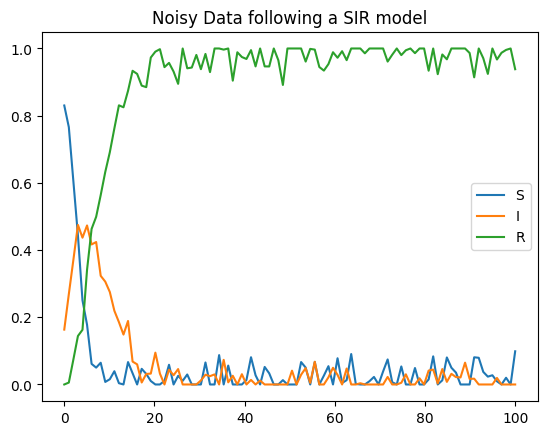

In [133]:
# Lets create the data

# Parameters (true values) : these are the parameters we want to recover
true_beta = 0.9
true_gamma = 0.2
true_y0 = np.array([0.89, 0.11, 0.0])

# time points
t = np.linspace(0, 100, 100)

# y
y = odeint(sir, true_y0, t, args=(true_beta, true_gamma))

# Add a little of random noise to the y to make it more realistic
y += np.random.normal(0, 0.04, y.shape)

# Creating a dataframe to make it easier to plot
y = pd.DataFrame(y, columns=["S", "I", "R"])

# Cropping the values into the range [0, 1] to make it more realistic
y[y < 0] = 0
y[y > 1] = 1

# Setting the index of the dataframe to the time
y.index=t

# Plotting the data
y.plot(title="Noisy Data following a SIR model")
plt.show()

Now that we have the data we can create a model and fit it to the data. We should be able to recover the parameters used to generate the data.

In [124]:
# Lets begin by defining the model

model = SIR(
  name="My sir",
  hyper_params={
    "time_space": (0, t.max()),
    "time_range": t,
  },
  train_params={
    "beta": 0.7,
    "gamma": 0.3,
    "initial_condition": np.array([0.99, 0.01, 0.0])
  },
  static_params={

  }
)

# Adding the data as train data to the model
model.train_data = y.values

model

Model: My sir
States: ['S', 'I', 'R']
Transitions: ['$\\beta SI$', '$\\gamma I$']
Has train data? True
Has test data? False
Trained? False

We instantiate the model object with the following parameters:

1. **name**: The name of the model.
2. **hyper_params**: The hyper parameters of the model. Those are parameters that are not trained but are used to define the model. In this case we define the time space and the time range.
3. **train_params**: The parameters that are trained by the model. In this case we define the initial condition and the initial guess of the parameters.
4. **static_params**: The parameters that are not trained and are not used to define the model. In this case we don't have any.


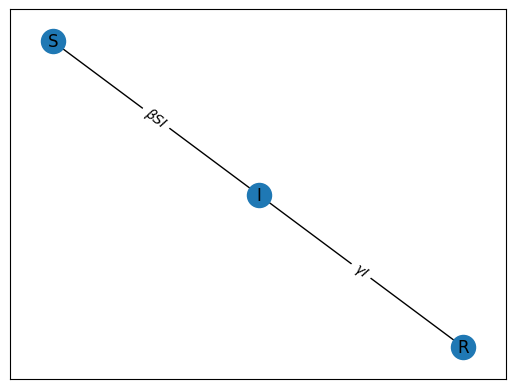

In [125]:
# Lets plot the model
model.plot_model()

We can see that the model is a SIR model with 3 compartments and 3 transitions. The model is fully defined by the graph and the parameters. In order to train the model we need to define a trainer. In this case we will use a Least Squares trainer that will fit the model to the data using least squares.

In [138]:
# Lets create a trainer and fit the model
trainer = LeastSquaresTrainer(model)
trainer.train()

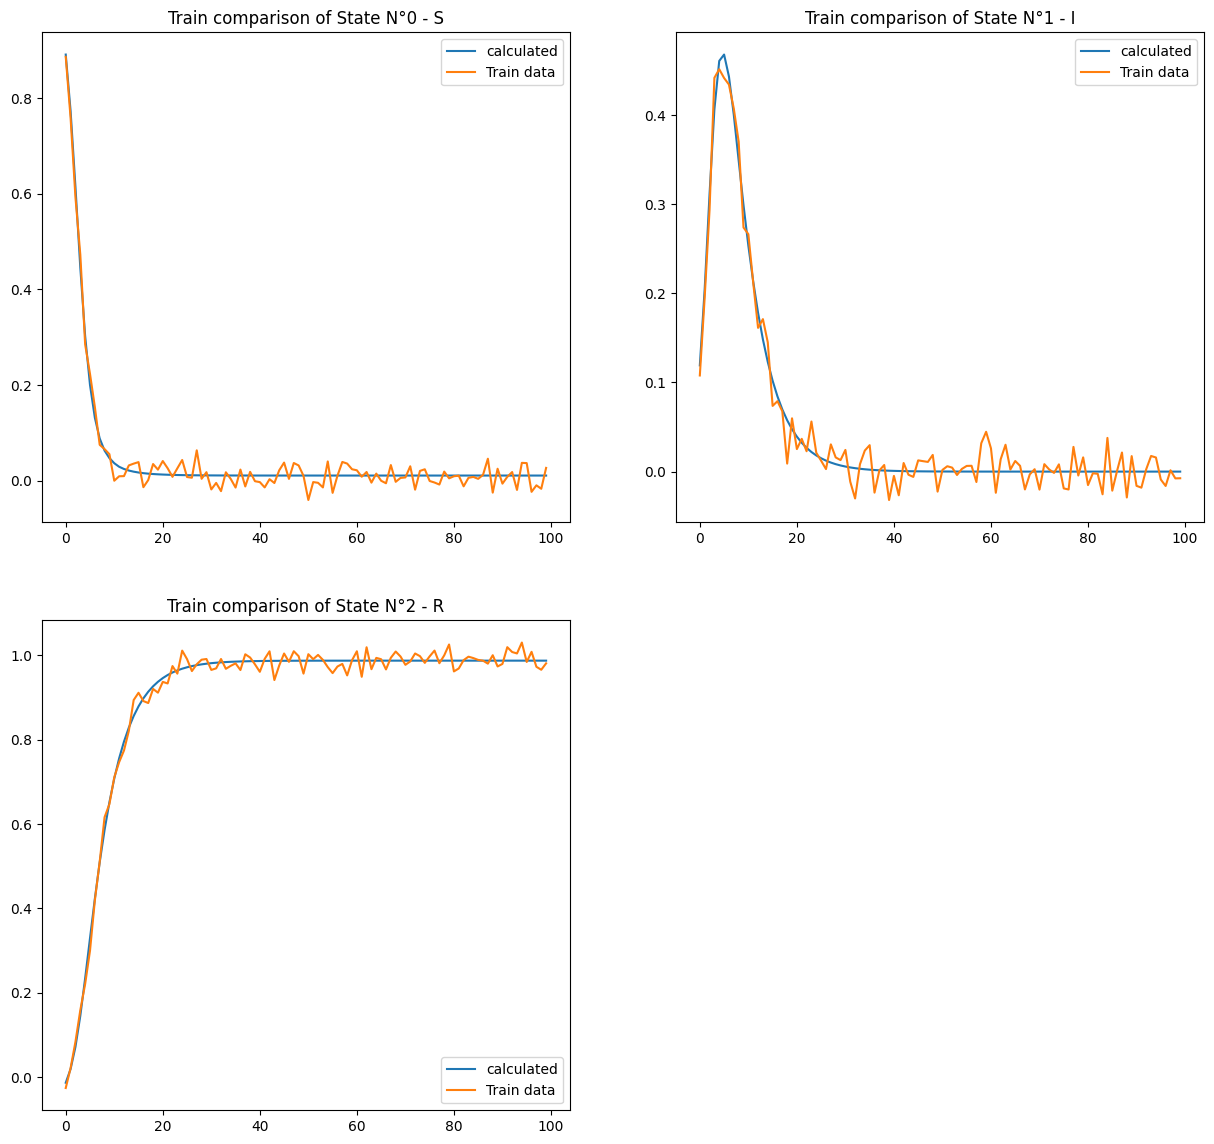

In [135]:
trainer.plot_train_curves()

In [141]:
print(trainer.model.train_params)

{'beta': array([0.88258194]), 'gamma': array([0.20166757]), 'initial_condition': array([ 0.89125681,  0.11915566, -0.01288286])}


We can see that the parameters recovered are very close to the true parameters used to generate the data. We can also see that the model is able to fit the data very well. Now lets use metrics to measure the performance of the model.



In [146]:
print("MSE: ", round(MSE(trainer.model.train_data, trainer.calculate_curves()), 4))


MSE:  0.0004


As we can see the model is able to fit the data very well and the MSE is very low. This finalizes the example of fitting a curve with a SIR model.

## Summary

- We can create a model by defining the graph and the parameters.
- We can train a model by using a trainer.
- We can test a model by using a metrics object.
